In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (
    precision_score, accuracy_score, recall_score, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, auc
)

import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/')
RAND_SEED = 11

df = pd.read_csv("creditcard.csv", sep=',')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_minority = df[df["Class"] == 1]
df_majority = df[df["Class"] == 0]

df_majority_down = df_majority.sample(
    frac=0.05,
    random_state=RAND_SEED
)

# 4. Recombine
df_reduced = pd.concat([df_minority, df_majority_down], axis=0)

# 5. (Optional) shuffle the rows
df_reduced = df_reduced.sample(frac=1.0, random_state=RAND_SEED).reset_index(drop=True)

X = df_reduced.drop("Class", axis=1)
y = df_reduced["Class"]

In [ ]:
# 1) Absolute counts
class_counts = df_reduced["Class"].value_counts()
print("Counts per class:")
print(class_counts)

# 2) Relative frequencies (percentages)
class_freq = df_reduced["Class"].value_counts(normalize=True) * 100
print("\nClass distribution (%):")
print(class_freq.round(2))

Counts per class:
Class
0    14216
1      492
Name: count, dtype: int64

Class distribution (%):
Class
0    96.65
1     3.35
Name: proportion, dtype: float64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=RAND_SEED
)

In [ ]:
train_pct = y_train.value_counts(normalize=True) * 100
print("Train set class distribution (size ",y_train.value_counts(),") (%):")
print(train_pct.round(2))

# 2) Compute percentage of each class in the test set
test_pct = y_test.value_counts(normalize=True) * 100
print("\nTest set class distribution (size ",y_test.value_counts(),") (%):")
print(test_pct.round(2))


Train set class distribution (size  Class
0    9951
1     344
Name: count, dtype: int64 ) (%):
Class
0    96.66
1     3.34
Name: proportion, dtype: float64

Test set class distribution (size  Class
0    4265
1     148
Name: count, dtype: int64 ) (%):
Class
0    96.65
1     3.35
Name: proportion, dtype: float64


In [ ]:
depth_values = [2,3,4,5,6,7]
lr_values = [0.1]
# n_estimators_range = [200]  # 10,20,...,200
n_estimators_range = np.arange(10, 301, 10)  # 10,20,...,200

results = []

Best parameters by test AUC: {'max_depth': 4.0, 'learning_rate': 0.1, 'n_estimators': 240.0, 'train_auc': 0.9856446296153477, 'test_auc': 0.9830558283958049}


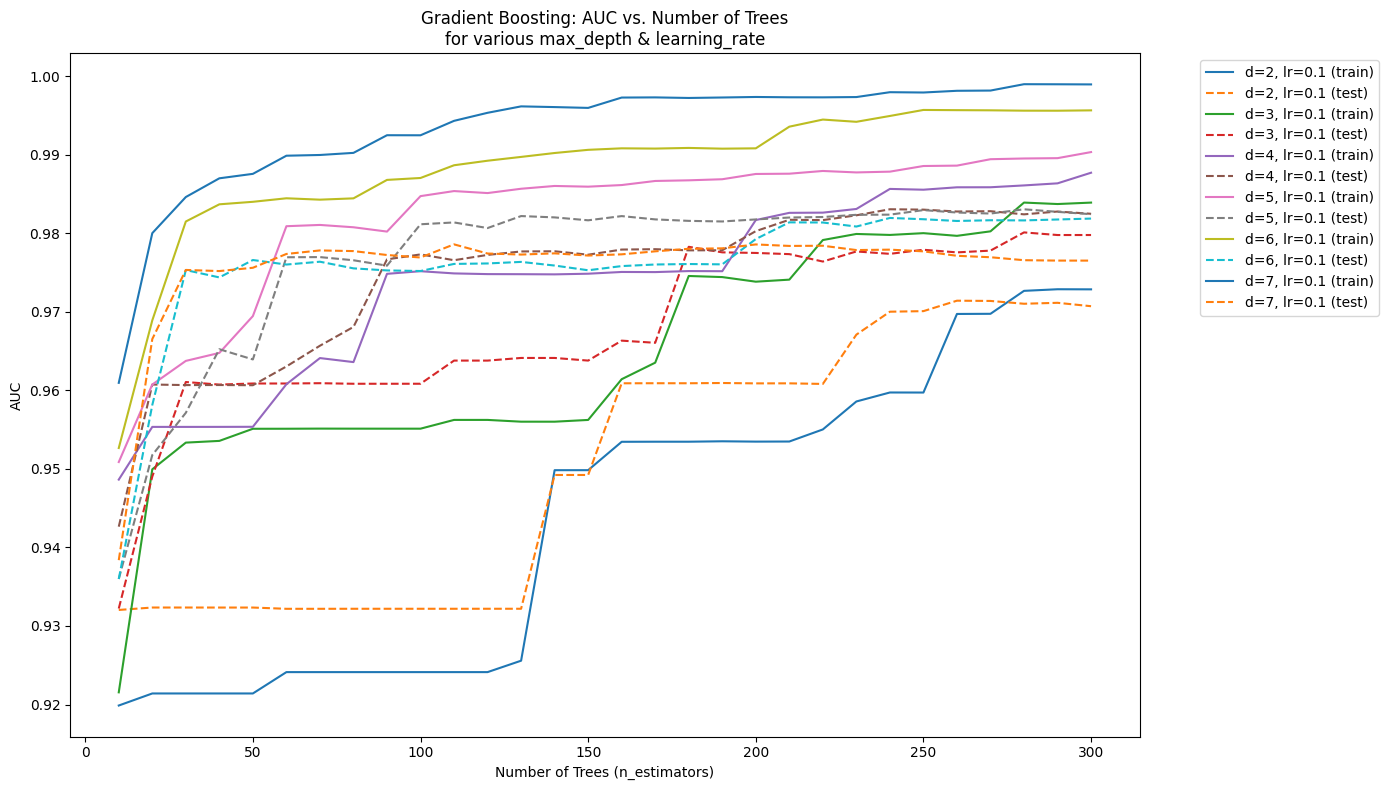

In [ ]:
results = []

for d in depth_values:
    for lr in lr_values:
        gbm = GradientBoostingClassifier(
            n_estimators=n_estimators_range[-1],
            max_depth=d,
            learning_rate=lr,
            random_state=RAND_SEED
        )
        gbm.fit(X_train, y_train)

        staged_train = list(gbm.staged_predict_proba(X_train))
        staged_test  = list(gbm.staged_predict_proba(X_test))

        for idx, n_est in enumerate(n_estimators_range):
            # TRAIN AUC
            proba_tr = staged_train[idx][:, 1]
            auc_tr   = roc_auc_score(y_train, proba_tr)

            # TEST AUC
            proba_te = staged_test[idx][:, 1]
            auc_te   = roc_auc_score(y_test, proba_te)

            results.append({
                'max_depth':     d,
                'learning_rate': lr,
                'n_estimators':  n_est,
                'train_auc':     auc_tr,
                'test_auc':      auc_te
            })

res_df = pd.DataFrame(results)
best = res_df.loc[res_df['test_auc'].idxmax()]
print("Best parameters by test AUC:", best.to_dict())

plt.figure(figsize=(14, 8))

for d in depth_values:
    for lr in lr_values:
        sub = res_df[(res_df['max_depth']==d) & (res_df['learning_rate']==lr)]
        # Train AUC
        plt.plot(
            sub['n_estimators'],
            sub['train_auc'],
            label=f"d={d}, lr={lr} (train)",
            linestyle='-'
        )
        # Test AUC
        plt.plot(
            sub['n_estimators'],
            sub['test_auc'],
            label=f"d={d}, lr={lr} (test)",
            linestyle='--'
        )

plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("AUC")
plt.title("Gradient Boosting: AUC vs. Number of Trees\nfor various max_depth & learning_rate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Put legend outside
plt.tight_layout()
plt.show()

In [ ]:
# Задание 2: точность, recall, specificity

print("=== Задание 2 ===")
gbm = GradientBoostingClassifier(
    n_estimators=int(best["n_estimators"]),
    max_depth=int(best["max_depth"]),
    learning_rate=best["learning_rate"],
    random_state=RAND_SEED
)
gbm.fit(X_train, y_train)

pred = gbm.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
print("Accuracy:   ", accuracy_score(y_test, pred))
print("Precision:   ", precision_score(y_test, pred))
print("Recall:     ", recall_score(y_test, pred))
print("Specificity:", tn/(tn+fp), "\n")

=== Задание 2 ===
Accuracy:    0.9929753002492635
Precision:    0.927007299270073
Recall:      0.8581081081081081
Specificity: 0.9976553341148886 



=== Задание 3 ===
ROC AUC: 0.9857173410221476


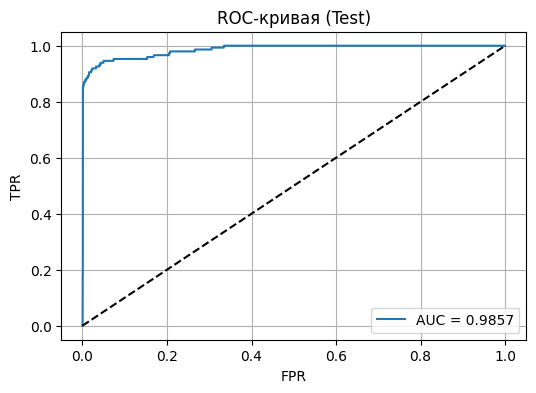

PR AUC: 0.8343323796591191


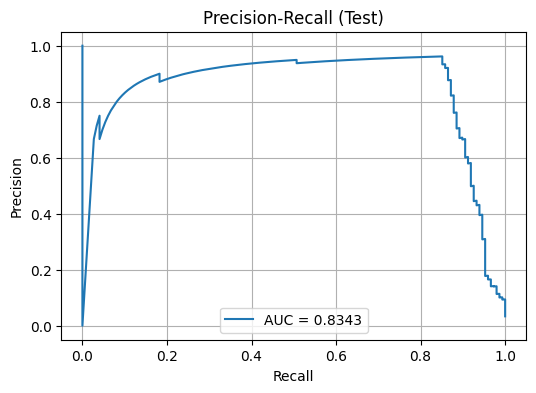

In [ ]:
# Задание 3: ROC + Precision-Recall + площади

print("=== Задание 3 ===")
proba = gbm.predict_proba(X_test)[:,1]

# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, proba)
roc_auc_val = roc_auc_score(y_test, proba)
print("ROC AUC:", roc_auc_val)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_val:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC-кривая (Test)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(); plt.show()

# Precision-Recall кривая
prec, rec, _ = precision_recall_curve(y_test, proba)
pr_auc_val   = auc(rec, prec)
print("PR AUC:", pr_auc_val)
plt.figure(figsize=(6,4))
plt.plot(rec, prec, label=f"AUC = {pr_auc_val:.4f}")
plt.title("Precision-Recall (Test)")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend(); plt.grid(); plt.show()
print()



=== Задание 4 ===
ROC AUC  1.0 Train
ROC AUC  0.9857173410221476 Test


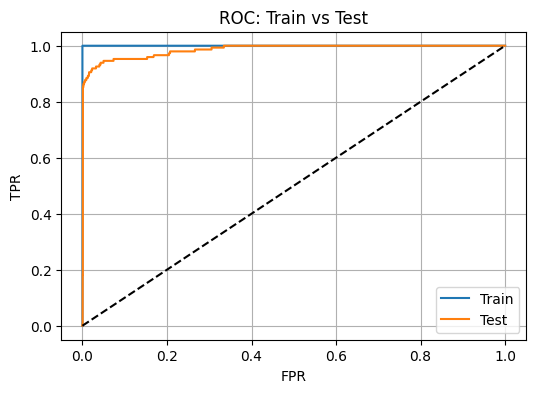

CV ROC AUC: 0.9748014518165722


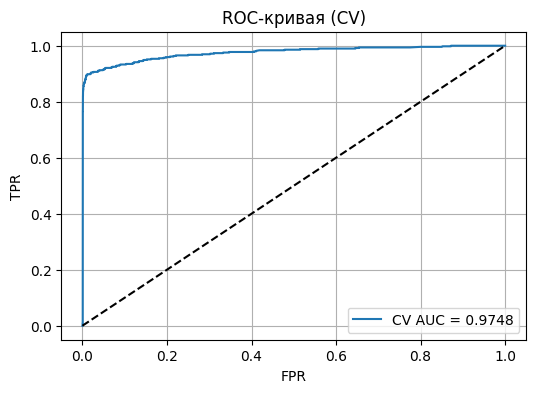

In [ ]:

# Задание 4: ROC для train/test и по CV

print("=== Задание 4 ===")
plt.figure(figsize=(6,4))
for label,(XX,yy) in [("Train",(X_train,y_train)), ("Test",(X_test,y_test))]:
    p_ = gbm.predict_proba(XX)[:,1]
    fpr_, tpr_, _ = roc_curve(yy, p_)
    print("ROC AUC ", roc_auc_score(yy, p_), label)
    plt.plot(fpr_, tpr_, label=label)
plt.plot([0,1],[0,1],'k--')
plt.title("ROC: Train vs Test"); plt.xlabel("FPR"); plt.ylabel("TPR")
plt.legend(); plt.grid(); plt.show()

cv    = StratifiedKFold(n_splits=5, shuffle=True, random_state=RAND_SEED)
p_cv  = cross_val_predict(gbm, X, y, cv=cv, method="predict_proba")[:,1]
fpr_cv, tpr_cv, _ = roc_curve(y, p_cv)
auc_cv = roc_auc_score(y, p_cv)
print("CV ROC AUC:", auc_cv)
plt.figure(figsize=(6,4))
plt.plot(fpr_cv, tpr_cv, label=f"CV AUC = {auc_cv:.4f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC-кривая (CV)")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.grid(); plt.show()
print()

In [ ]:
# Задание 5: сравнение loss-функции и exp

print("=== Задание 5 ===")
for loss in ["log_loss","exponential"]:
    loss_test_clf = GradientBoostingClassifier(
      n_estimators=int(best["n_estimators"]),
      max_depth=int(best["max_depth"]),
      learning_rate=best["learning_rate"],
      random_state=RAND_SEED,
      loss=loss
    )
    loss_test_clf.fit(X_train, y_train)
    auc_loss = roc_auc_score(y_test, loss_test_clf.predict_proba(X_test)[:,1])
    print(f"GBM loss={loss:<11} → AUC = {auc_loss:.4f}")

=== Задание 5 ===
GBM loss=log_loss    → AUC = 0.9857
GBM loss=exponential → AUC = 0.9818


In [ ]:
ada = AdaBoostClassifier(n_estimators=240, random_state=RAND_SEED).fit(X_train, y_train)
auc_ada = roc_auc_score(y_test, ada.predict_proba(X_test)[:,1])
print(f"AdaBoost        → AUC = {auc_ada:.4f}\n")

AdaBoost        → AUC = 0.9856



In [ ]:
# Задание 6: балансировка через sample_weight

print("=== Задание 6 ===")

# Исходная точность без балансировки
pred_original = gbm.predict(X_test)
accuracy_original = accuracy_score(y_test, pred_original)
precision_original = precision_score(y_test, pred_original)

# Правильная балансировка классов через веса:
w0 = len(y_train) / (2 * np.sum(y_train == 0))
w1 = len(y_train) / (2 * np.sum(y_train == 1))
sample_weight = np.where(y_train == 0, w0, w1)

=== Задание 6 ===


In [ ]:
gbm_balanced = GradientBoostingClassifier(
    n_estimators=int(best["n_estimators"]),
    max_depth=int(best["max_depth"]),
    learning_rate=best["learning_rate"],
    random_state=RAND_SEED,
).fit(X_train, y_train, sample_weight=sample_weight)

# Точность после балансировки
pred_balanced = gbm_balanced.predict(X_test)
accuracy_balanced = accuracy_score(y_test, pred_balanced)
precision_balanced = precision_score(y_test, pred_balanced)

# Сравнение точностей
print(f"Accuracy без балансировки:   {accuracy_original:.4f}")
print(f"Precision без балансировки:   {precision_original:.4f}")
print(f"Accuracy после балансировки: {accuracy_balanced:.4f}")
print(f"Precision после балансировки: {precision_balanced:.4f}")

Accuracy без балансировки:   0.9930
Precision без балансировки:   0.9270
Accuracy после балансировки: 0.9939
Precision после балансировки: 0.9416


=== Метрики ДО балансировки ===
              precision    recall  f1-score   support

           0     0.9951    0.9977    0.9964      4265
           1     0.9270    0.8581    0.8912       148

    accuracy                         0.9930      4413
   macro avg     0.9610    0.9279    0.9438      4413
weighted avg     0.9928    0.9930    0.9928      4413

ROC AUC до балансировки: 0.9857
PR AUC до балансировки: 0.8343

=== Метрики ПОСЛЕ балансировки ===
              precision    recall  f1-score   support

           0     0.9956    0.9981    0.9968      4265
           1     0.9416    0.8716    0.9053       148

    accuracy                         0.9939      4413
   macro avg     0.9686    0.9349    0.9511      4413
weighted avg     0.9937    0.9939    0.9938      4413

ROC AUC после балансировки: 0.9765
PR AUC после балансировки: 0.9224


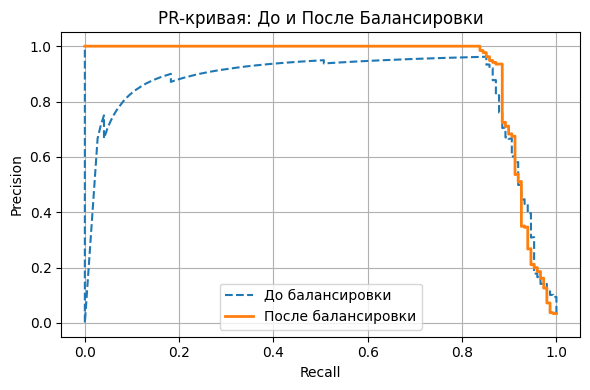

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt


print("=== Метрики ДО балансировки ===")
y_pred_before = gbm.predict(X_test)
y_prob_before = gbm.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_before, digits=4))
print("ROC AUC до балансировки:", round(roc_auc_score(y_test, y_prob_before), 4))
prec_b, rec_b, _ = precision_recall_curve(y_test, y_prob_before)
print("PR AUC до балансировки:", round(auc(rec_b, prec_b), 4))


print("\n=== Метрики ПОСЛЕ балансировки ===")
y_pred_after = gbm_balanced.predict(X_test)
y_prob_after = gbm_balanced.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_after, digits=4))
print("ROC AUC после балансировки:", round(roc_auc_score(y_test, y_prob_after), 4))
prec_a, rec_a, _ = precision_recall_curve(y_test, y_prob_after)
print("PR AUC после балансировки:", round(auc(rec_a, prec_a), 4))


plt.figure(figsize=(6,4))
plt.plot(rec_b, prec_b, label="До балансировки", linestyle='--')
plt.plot(rec_a, prec_a, label="После балансировки", linewidth=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR-кривая: До и После Балансировки")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
